In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import random
from typing import Callable
import time

## Загрузка базы данных MNIST

In [5]:
def load_mnist(path):
    with open(path, mode='rb') as f:
        training_data, _, test_data = pickle.load(f, encoding='bytes')
        return dict(
            training_images = training_data[0],
            training_labels = training_data[1],
            test_images = test_data[0],
            test_labels = test_data[1]
        )

## Рисование цифры MNIST

In [6]:
def draw_mnist_digit(mnist, example):
    label = mnist['training_labels'][example]
    plt.title('Example: %d, label: %d' % (example, label))
    plt.imshow(np.array(mnist['training_images'][7]).reshape((28, 28)), cmap=plt.get_cmap('gray'))

## Стохастический градиентный спуск

In [7]:
class SGD():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_network(self, network):
        self.network = network
    
    def update(self, grad_w, grad_b, batch, expected):
        for i in range(len(self.network.layers) - 1, 0, -1):
            self.network.weights[i] -= self.learning_rate * grad_w[i]
            self.network.biases[i] -= self.learning_rate * grad_b[i]

    def __str__(self):
        return 'SGD'

## Сопряжённые градиенты (метод Флетчера-Ривза FR)

In [8]:
class ConjugateGradientFR():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_network(self, network):
        self.network = network
        self.prev_grad_w = None
        self.previous_d = None

    def update(self, grad_w, grad_b, batch, expected):
        if self.previous_d is None:
            self.previous_d = [-grad_w[i] for i in range(1, len(self.network.layers))]
        else:
            beta = [np.zeros((grad_w[i].shape[0], 1)) for i in range(1, len(self.network.layers))]
            for i in range(1, len(self.network.layers)):
                numerator = np.diagonal(np.dot(grad_w[i], np.transpose(grad_w[i])))
                denominator = np.diagonal(np.dot(self.prev_grad_w[i], np.transpose(self.prev_grad_w[i])))
                beta[i - 1] = numerator / (denominator + 1e-100)
                beta[i - 1] = np.where(beta[i - 1] < 1, beta[i - 1], 0)
                for j in range(beta[i - 1].shape[0]):
                    self.previous_d[i - 1][j] = -grad_w[i][j] + beta[i - 1][j] * self.previous_d[i - 1][j]
            # self.previous_d = [-grad_w[i] + np.dot(beta[i - 1], self.previous_d[i - 1]) for i in range(1, len(self.network.layers))]
        for i in range(1, len(self.network.layers)):
            self.network.weights[i] += self.learning_rate * self.previous_d[i - 1]
            self.network.biases[i] -= self.learning_rate * grad_b[i]
        self.prev_grad_w = grad_w

    def __str__(self):
        return 'Conjugate Gradient FR'

## Метод Бройдена-Флетчера-Гольдфарба-Шенно (BFGS)

In [41]:
class BFGS():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_network(self, network):
        self.network = network
        self.H = [None] + [np.eye(self.network.weights[i].shape[0]) for i in range(1, len(self.network.layers))]
        self.prev_grad_w = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.layers))]
        self.prev_weights = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.layers))]

    def update(self, grad_w, grad_b):
        for i in range(1, len(self.network.layers)):
            delta_w = -self.learning_rate * np.dot(self.H[i], grad_w[i])
            delta_b = -self.learning_rate * grad_b[i]
            self.network.weights[i] += delta_w
            self.network.biases[i] += delta_b

            delta_grad_w_i = grad_w[i] - self.prev_grad_w[i]
            delta_weight_i = self.network.weights[i] - self.prev_weights[i]
            
            rho = 1.0 / (np.dot(delta_weight_i, np.transpose(delta_grad_w_i)) + 1e-100)
            rho = np.where((rho > 0) & (rho < 1) , rho, 0)
            self.H[i] = (np.eye(self.network.weights[i].shape[0]) - \
                        rho * np.dot(delta_weight_i, np.transpose(delta_grad_w_i))) * self.H[i] * \
                        (np.eye(self.network.weights[i].shape[0]) - \
                        rho * np.dot(delta_grad_w_i, np.transpose(delta_weight_i))) + \
                        rho * np.dot(delta_weight_i, np.transpose(delta_weight_i))
        self.prev_grad_w = grad_w
        self.prev_weights = deepcopy(self.network.weights)

    def __str__(self):
        return 'BFGS'

# Ускоренный градиент Нестерова (Nesterov accelerated gradient)

In [42]:
class NAG():
    def __init__(self, learning_rate, gamma):
        self.learning_rate = learning_rate
        self.gamma = gamma

    def init_network(self, network):
        self.network = network
        self.vt_w = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.weights))]
        self.vt_b = [None] + [np.zeros_like(self.network.biases[i]) for i in range(1, len(self.network.biases))]
        
    def update(self, grad_w, grad_b, batch, expected):
        network_predicted = deepcopy(self.network)
        for i in range(1, len(self.network.layers)):
            network_predicted.weights[i] -= self.gamma * self.vt_w[i]
            network_predicted.biases[i] -= self.gamma * self.vt_b[i]

        weighted_inputs, predicted = network_predicted.feedforward(np.transpose(batch))
        errors = network_predicted.backpropogate_error(weighted_inputs, predicted[-1], expected)
        grad_w_predicted = [None for _ in range(len(network_predicted.layers))]
        grad_b_predicted = [None for _ in range(len(network_predicted.layers))]
        for i in range(len(network_predicted.layers) - 1, 0, -1):
            grad_w_predicted[i] = np.dot(errors[i], np.transpose(predicted[i - 1])) / batch.shape[0]
            grad_b_predicted[i] = errors[i].sum(axis=1) / batch.shape[0]
        
        for i in range(1, len(self.network.layers)):
            self.vt_w[i] = self.gamma * self.vt_w[i] + self.learning_rate * grad_w_predicted[i]
            self.vt_b[i] = self.gamma * self.vt_b[i] + self.learning_rate * grad_b_predicted[i] 
            self.network.weights[i] -= self.vt_w[i]
            self.network.biases[i] -= self.vt_b[i]

    def __str__(self):
        return 'NAG'

# Адаптивный градиент (Adagrad)

In [43]:
class Adagrad():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def init_network(self, network):
        self.network = network
        self.G_w = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.weights))]
        self.G_b = [None] + [np.zeros_like(self.network.biases[i]) for i in range(1, len(self.network.biases))]
        
    def update(self, grad_w, grad_b, batch, expected):
        for i in range(1, len(self.network.layers)):
            self.G_w[i] += grad_w[i] ** 2
            self.G_b[i] += grad_b[i] ** 2
            adapted_learning_rate_w = self.learning_rate / np.sqrt(self.G_w[i] + 1e-8)
            adapted_learning_rate_b = self.learning_rate / np.sqrt(self.G_b[i] + 1e-8)
            self.network.weights[i] -= adapted_learning_rate_w * grad_w[i]
            self.network.biases[i] -= adapted_learning_rate_b * grad_b[i]

    def __str__(self):
        return 'Adagrad'

# Метод адаптивной оценки моментов (Adam)

In [44]:
class Adam():
    def __init__(self, learning_rate, beta1, beta2):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2

    def init_network(self, network):
        self.network = network
        self.m_w = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.weights))]
        self.v_w = [None] + [np.zeros_like(self.network.weights[i]) for i in range(1, len(self.network.weights))]
        self.m_b = [None] + [np.zeros_like(self.network.biases[i]) for i in range(1, len(self.network.biases))]
        self.v_b = [None] + [np.zeros_like(self.network.biases[i]) for i in range(1, len(self.network.biases))]
        self.epoch = 1
        
    def update(self, grad_w, grad_b, batch, expected):
        for i in range(1, len(self.network.layers)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grad_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grad_b[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grad_w[i] ** 2
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grad_b[i] ** 2

            m_w_i = self.m_w[i] / (1 - self.beta1 ** self.epoch)
            m_b_i = self.m_b[i] / (1 - self.beta1 ** self.epoch)
            v_w_i = self.v_w[i] / (1 - self.beta2 ** self.epoch)
            v_b_i = self.v_b[i] / (1 - self.beta2 ** self.epoch)
            
            self.network.weights[i] -= self.learning_rate * m_w_i / (np.sqrt(v_w_i) + 1e-8)
            self.network.biases[i] -= self.learning_rate * m_b_i / (np.sqrt(v_b_i) + 1e-8)
        self.epoch += 1

    def __str__(self):
        return 'Adam'

# Средняя квадратичная ошибка

In [18]:
class MeanSquaredError():
    # средняя квадратичная ошибка
    @staticmethod
    def calculate(expected, predicted):
        return np.mean((expected - predicted) ** 2)

# Категориальная перекрёстная энтропия

In [19]:
class CategorialCrossEntropy():
    # категориальная перекрёстная энтропия
    @staticmethod
    def calculate(expected, predicted):
        return -np.sum(expected * np.log(predicted + 1e-100))

# Дивергенция Кульбака-Лейблера

In [20]:
class KLDivergence():
    # дивергенция Кульбака-Лейблера
    @staticmethod
    def calculate(expected, predicted):
        return np.sum(expected * np.log((expected + 1e-100) / (predicted + 1e-100)))

## Класс для представления многослойного персептрона

In [16]:
class Perceptron:
    def __init__(self, layers, optimizer):
        # layers-- это кортеж, каждый элемент которого
        # представляет количество нейронов в соответствующем слое 
        self.layers = layers
        self.weights = [None]
        self.biases = [None]
        # инициализация весов и bias-ов в каждом слое
        # для входного слоя веса и bias-ы не нужны
        for i in range(1, len(self.layers)):
            self.weights.append(np.random.normal(0.0, np.sqrt(2.0 / (self.layers[i - 1] + self.layers[i])), size=(self.layers[i], self.layers[i - 1])))
            self.biases.append(np.random.normal(0.0,  np.sqrt(2.0 / (self.layers[i - 1] + self.layers[i])), size=self.layers[i]))
        self.optimizer = optimizer
        self.optimizer.init_network(self)
    
    @staticmethod
    def relu(x):
        #return 1 / (1 + np.exp(np.clip(-x, a_min=-100, a_max=100)))
        return np.vectorize(lambda x: x if x >= 0 else 0)(x)
    
    @staticmethod
    def softmax(x):
        return np.exp(x - max(x)) / np.sum(np.exp(x - max(x)))
    
    def activate(self, x, activation):
        if activation not in ('relu', 'softmax'):
            raise Exception('activation should be "relu" or "softmax"')
        if activation == 'relu':
            return self.relu(x)
        return np.apply_along_axis(self.softmax, 0, x)
    
    def activation_func_derivative(self, x, activation):
        if activation not in ('relu', 'softmax'):
            raise Exception('activation should be "relu" or "softmax"')
        if activation == 'relu':
             #return self.activate(x, 'relu') * (1 - self.activate(x, 'relu'))
            return np.vectorize(lambda x: 1 if x >= 0 else 0)(x)
        return self.activate(x, 'softmax') * (1 - self.activate(x, 'softmax'))
    
    def feedforward(self, input):
        weighted_inputs, outputs = [None], [input]
        for i in range(1, len(self.layers)):
            weighted_input = np.dot(self.weights[i], outputs[i - 1]) + self.biases[i].reshape(self.layers[i], 1)
            output = self.activate(weighted_input, 'relu') if i != len(self.layers) - 1 else self.activate(weighted_input, 'softmax')
            weighted_inputs.append(weighted_input)
            outputs.append(output)
        return (weighted_inputs, outputs)
    
    def train(self, training_data, test_data, epochs, batch_size, loss_func, is_loss_funcs_plot_needed):
        self.loss_func = loss_func
        training_data = list(zip(training_data['training_images'], training_data['training_expected']))
        x, y = [], []
        for epoch in range(1, epochs + 1):
            loss = 0
            np.random.shuffle(training_data)
            training_images, training_expected = zip(*training_data)
            training_images, training_expected = np.array(training_images), np.array(training_expected)
            n = 0
            for i in range(0, training_images.shape[0], batch_size):
                batch = training_images[i: i + batch_size]
                expected = np.transpose(training_expected[i: i + batch_size])
                weighted_inputs, predicted = self.feedforward(np.transpose(batch))
                errors = self.backpropogate_error(weighted_inputs, predicted[-1], expected)
                grad_w, grad_b = [None for _ in range(len(self.layers))], [None for _ in range(len(self.layers))]
                for i in range(len(self.layers) - 1, 0, -1):
                    grad_w[i] = np.dot(errors[i], np.transpose(predicted[i - 1])) / batch_size
                    grad_b[i] = errors[i].sum(axis=1) / batch_size
                self.optimizer.update(grad_w, grad_b, batch, expected)
                loss += loss_func.calculate(expected=expected, predicted=predicted[-1]) / batch_size
                n += 1
            loss /= n
            score, _ = self.predict(test_data=test_data)
            # print(f'Epoch {epoch}\{epochs}\nloss: {loss: .2f}, accuracy: {score: .2f}%')
            x.append(epoch)
            y.append(loss)
        self.loss_func_values = y
        if is_loss_funcs_plot_needed:
            self.plot_loss_funcs(x, y)

    def backpropogate_error(self, weighted_inputs, predicted_data, expected_data):
        errors = [None for _ in self.layers]
        # errors[-1] = 2 * (predicted_data - expected_data) / predicted_data.shape[1] #* self.activation_func_derivative(weighted_inputs[-1], 'relu')
        errors[-1] = predicted_data - expected_data
        for i in range(len(self.layers) - 2, 0, -1):
            errors[i] = np.dot(np.transpose(self.weights[i + 1]), errors[i + 1]) * \
                  self.activation_func_derivative(weighted_inputs[i], 'relu')
        return errors
    
    def predict(self, test_data):
        score, loss, n = 0, 0, 0
        for test_image, test_expected in zip(test_data['test_images'], test_data['test_expected']):
            predicted = self.feedforward(test_image.reshape(784, 1))[1][-1]
            predicted_label = np.argmax(predicted)
            expected_label = np.argmax(test_expected)
            score = score + 1 if predicted_label == expected_label else score
            loss += self.loss_func.calculate(expected=test_expected, predicted=predicted)
            n += 1
        return score / n * 100, loss / test_data['test_images'].shape[0]
    
    def plot_loss_funcs(self, x, y):
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(x, y, label='cross_entropy_loss', c='red')
        plt.legend(loc='upper right')
        plt.show()
            
    def get_loss_values(self):
        return self.loss_func_values

## Тестирование
### Рисование цифры MNIST

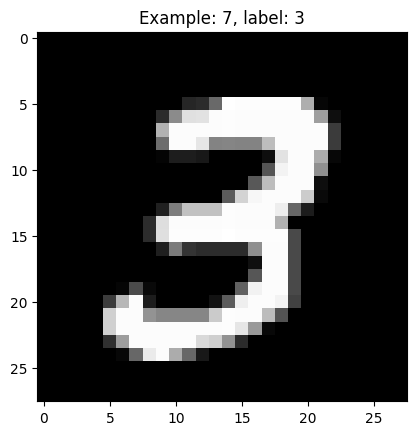

In [10]:
mnist = load_mnist('mnist.pkl')
draw_mnist_digit(mnist, example=7)

### Подготовка данных для обучения

In [11]:
training_expected = np.array([[1.0 if i == label else 0 for i in range(10)] for label in mnist['training_labels']])
training_data = dict(
    training_images=mnist['training_images'],
    training_expected=training_expected
)
test_expected = np.array([[1.0 if i == label else 0 for i in range(10)] for label in mnist['test_labels']])
test_data = dict(
    test_images=mnist['test_images'],
    test_expected=test_expected
)

### Обучение и тестирование многослойного персептрона
В качестве функции активации используется `ReLu`, а на последнем слое - `Softmax`

In [21]:
epochs = 10

perceptron = Perceptron(layers=(784, 32, 32, 32, 10), optimizer=SGD(0.01))
perceptron.train(
    training_data=training_data,
    test_data=test_data,
    epochs=epochs,
    batch_size=70,
    loss_func=CategorialCrossEntropy(),
    is_loss_funcs_plot_needed=True
)
score, _ = perceptron.predict(test_data=test_data)
print(f'Accuracy of guessed numbers: {score: .2f}%')

KeyboardInterrupt: 

### Использование методов оптимизации

Optimization method: SGD
Accuracy of guessed numbers: 92.07%
Optimization method: NAG
Accuracy of guessed numbers: 95.09%
Optimization method: Adagrad
Accuracy of guessed numbers: 93.63%
Optimization method: Adam
Accuracy of guessed numbers: 95.26%


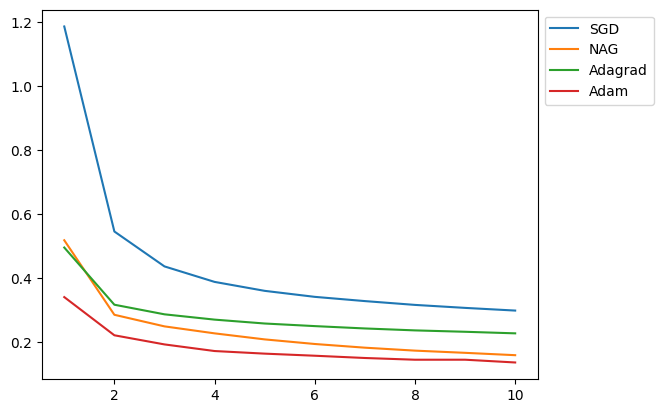

In [ ]:
optimizers = (
    SGD(0.01),
    NAG(0.01, 0.9),
    Adagrad(0.01),
    Adam(0.01, 0.9, 0.99)
)

y_s = list()
for optimizer in optimizers:
    perceptron = Perceptron(layers=(784, 18, 10), optimizer=optimizer)
    perceptron.train(
        training_data=training_data,
        test_data=test_data,
        epochs=epochs,
        batch_size=70,
        loss_func=CategorialCrossEntropy(),
        is_loss_funcs_plot_needed=False
    )
    y_s.append(perceptron.get_loss_values())
    score, _ = perceptron.predict(test_data=test_data)
    print(f'Optimization method: {str(optimizer)}')
    print(f'Accuracy of guessed numbers: {score}%')

for i, optimizer in enumerate(optimizers):
    x, y = range(1, epochs + 1), y_s[i]
    plt.plot(x, y, label=str(optimizer))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Оптимизация гиперпараметров (число слоёв, число нейронов в слое)
### Использование для этой цели генетического алгоритма

In [24]:
epochs = 100

training_data['training_images'] = training_data['training_images'][:2000]
training_data['training_expected'] = training_data['training_expected'][:2000]
test_data['test_images'] = test_data['test_images'][:2000]
test_data['test_expected'] = test_data['test_expected'][:2000]

def create_neural_network(genome):
    # genome[0] - количество слоев, genome[1] - количество нейронов в промежуточном слое
    network = Perceptron(layers=[784] +  genome[0] * [genome[1]] + [10], optimizer=SGD(0.01))
    return network

def train_and_evaluate(genome):
    network = create_neural_network(genome)
    network.train(
        training_data=training_data,
        test_data=test_data,
        epochs=epochs,
        batch_size=70,
        loss_func=CategorialCrossEntropy(),
        is_loss_funcs_plot_needed=False
    )
    accuracy, _ = network.predict(test_data=test_data)
    return accuracy
    
def fitness_func(genome):
    start_time = time.time()
    accuracy = train_and_evaluate(genome)
    end_time = time.time()
    completion_time = end_time - start_time
    
    return accuracy / 10 if accuracy < 74 else 10 + (accuracy - 74) ** 4 - (completion_time / 60) 

def genetic_algorithm() -> tuple[np.ndarray, float]:
    t, Np, k, Mp = 0, 4, 1, 10
    # размер генома
    n = 2
    # формируем исходную популяцию с количеством особей Mp
    population = []
    Mp = 0
    for i in range(1, 3):
        for j in range (1, 5):
            Mp += 1
            population.append([i, j])

    population = np.array(population)
    fitness_values_individuals_hist = {}
    fitness_values_individuals = []

    for genome, fitness_value in zip(population, np.array(list(map(fitness_func, population)))):
        fitness_values_individuals_hist[str(genome)] = fitness_value
        fitness_values_individuals.append(fitness_value)

    # print(population)
    # print(fitness_values_individuals_hist)

    fitness_value_population = np.sum(fitness_values_individuals)

    while t != Np:
        k = 1
        while k < Mp:
            # этап селекции (отбора особей) для последующего их скрещивания
            q = fitness_values_individuals / fitness_value_population
            new_population = [population[np.random.choice(len(population), p=q)] for _ in range(Mp)]

            # этап скрещивания
            Pc = 0.5
            parent_indices = []
            for i in range(len(new_population)):
                r = np.random.random()
                if r < Pc:
                    parent_indices.append(i)

            for parent1_index, parent2_index in zip(parent_indices[0::2], parent_indices[1::2]):
                c = np.random.random()
                parent1, parent2 = new_population[parent1_index], new_population[parent2_index]
                parent1 = c * parent1 + (1 - c) * parent2
                parent2 = (1 - c) * parent1 + c * parent2
                
            # этап мутации
            Pm = 0.2
            for i in range(len(new_population)):
                r = np.random.random()
                if r < Pm:
                    p = np.random.randint(0, n, 1)
                    if p == 0:
                        new_population[i][p] = np.random.randint(1, 16)
                    else:
                        new_population[i][p] = np.random.randint(1, 33)

            population[:] = new_population

            fitness_values_individuals = []
            for genome in population:
                if fitness_values_individuals_hist.get(str(genome)) is None:
                    fitness_values_individuals_hist[str(genome)] = fitness_func(genome)
                fitness_values_individuals.append(fitness_values_individuals_hist[str(genome)])
            
            fitness_value_population = np.sum(fitness_values_individuals)
            k += 1
        t += 1
    # print(list(zip(population, fitness_values_individuals)))
    best_individual = population[np.argmax(fitness_values_individuals)]
    return best_individual, fitness_values_individuals[np.argmax(fitness_values_individuals)]

x, y = genetic_algorithm()
print(f'Best individual: {x}')

KeyboardInterrupt: 